# Basketball Playoffs Qualification

## Task description

Basketball tournaments are usually split in two parts. First, all teams play each other aiming to achieve the greatest number of wins possible. Then, at the end of the first part of the season, a pre determined number of teams which were able to win the most games are qualified to the playoff season, where they play series of knock-out matches for the trophy.

For the 10 years, data from players, teams, coaches, games and several other metrics were gathered and arranged on this dataset. The goal is to use this data to predict which teams will qualify for the playoffs in the next season.

## Data preparation

### Creating the database

First, we need to convert the CSV files to tables in an SQLite database, so we can analyze, manipulate and prepare data more easily. This was done with a couple of SQlite3 commands:

```
.mode csv
.import dataset/awards_players.csv awards_players
.import dataset/coaches.csv coaches
.import dataset/players.csv players
.import dataset/players_teams.csv players_teams
.import dataset/series_post.csv series_post
.import dataset/teams_post.csv teams_post
.import dataset/teams.csv teams
.save database.db
```

### Filtering unneeded rows and columns

Upon closer inspection of the dataset, we found some rows which had no effect or could have a negative impact in our models training, such as rows in the players table which corresponded to current coaches, and thus had no information related to their height, weight, etc.

## Model performance measures

### The Game Score measure
The Game Score measure, created by John Hollinger, attempts to give an estimation of a player's productivity for a single game. We will start working on our model based on this measure, applying it to each player based on a whole season's stats and dividing it by the amount of games played.

### Basketball Power Index


Import necessary packages

In [732]:
import sqlite3
import pandas as pd

Create dataframes based on the database and relations between data and remove the duplicate columns that may exist.

In [733]:
con = sqlite3.connect("database.db")

# Player <-> Awards
pl_aw = pd.read_sql_query("SELECT * FROM awards_players INNER JOIN players ON awards_players.playerID = players.bioID", con)

# Player <-> Teams
pl_tm = pd.read_sql_query("SELECT * FROM players_teams INNER JOIN players ON players_teams.playerID = players.bioID", con)

# Teams <-> Post Season Results (aggregated)
tm_psa = pd.read_sql_query("SELECT * FROM teams_post INNER JOIN teams ON (teams_post.tmID = teams.tmID AND teams_post.year = teams.year)", con)

# Coach <-> Teams
cc_tm = pd.read_sql_query("SELECT * FROM coaches INNER JOIN teams ON (coaches.tmID = teams.tmID AND coaches.year = teams.year)", con)


pl_aw = pl_aw.loc[:,~pl_aw.columns.duplicated()]
pl_tm = pl_tm.loc[:,~pl_tm.columns.duplicated()]
tm_psa = tm_psa.loc[:,~tm_psa.columns.duplicated()]
cc_tm = cc_tm.loc[:,~cc_tm.columns.duplicated()]

## Data Pre-processing

### Column dropping

First, remove columns that only have null values or no unique values.

In [734]:
dataframes = [pl_aw, pl_tm, tm_psa, cc_tm]

for i in range(len(dataframes)):
    unique_counts = dataframes[i].nunique()
    dropped_columns = dataframes[i].columns[(dataframes[i].isna().sum() == len(dataframes[i])) | (unique_counts == 1)]
    
    print(f"Dropped columns in dataframe {i}: {list(dropped_columns)}")
    
    dataframes[i] = dataframes[i].drop(columns=dropped_columns, axis=1, inplace=True)

Dropped columns in dataframe 0: ['lgID', 'firstseason', 'lastseason', 'collegeOther', 'deathDate']
Dropped columns in dataframe 1: ['lgID', 'firstseason', 'lastseason']
Dropped columns in dataframe 2: ['lgID', 'divID', 'playoff', 'seeded', 'tmORB', 'tmDRB', 'tmTRB', 'opptmORB', 'opptmDRB', 'opptmTRB']
Dropped columns in dataframe 3: ['lgID', 'divID', 'seeded', 'tmORB', 'tmDRB', 'tmTRB', 'opptmORB', 'opptmDRB', 'opptmTRB']


Now, we remove Player rows that have birth-date `0000-00-00`.

In [735]:
pl_aw = pl_aw.drop(pl_aw[pl_aw['birthDate'] == '0000-00-00'].index, axis = 0)
pl_tm = pl_tm.drop(pl_tm[pl_tm['birthDate'] == '0000-00-00'].index, axis = 0)

Lastly, when applicable, we remove the Team `name` attribute, since we already have access to the `tmID`.

In [736]:
tm_psa = tm_psa.drop(['name'], axis=1)
cc_tm = cc_tm.drop(['name'], axis=1)

In [737]:
# TODO give different values to different awards, more priority to recent year awards
# TODO correlation matrix between attributes in player, team & coach
# TODO Meter todas as coisas limpas num csv

### Outliers

Now, to analyse the `weight` and `height` attributes' Z-Score and IQR.

In [746]:
import matplotlib.pyplot as plt
import scipy.stats as stats

Height Z-Score
 0     0.462795
1     1.315661
2     1.315661
3    -0.105782
4    -0.105782
        ...   
90   -0.958648
91    0.462795
92   -0.390070
93   -0.105782
94   -1.242936
Name: height, Length: 86, dtype: float64

Weight Z-Score
 0     0.731387
1     0.326565
2     0.326565
3     0.275962
4    -0.938505
        ...   
90   -0.685491
91    0.427770
92   -0.938505
93    0.427770
94   -0.128861
Name: weight, Length: 86, dtype: float64


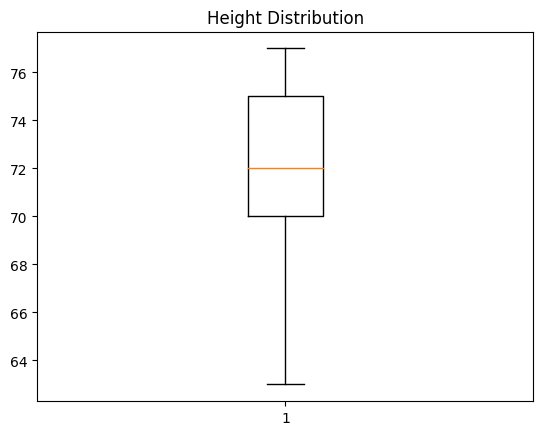

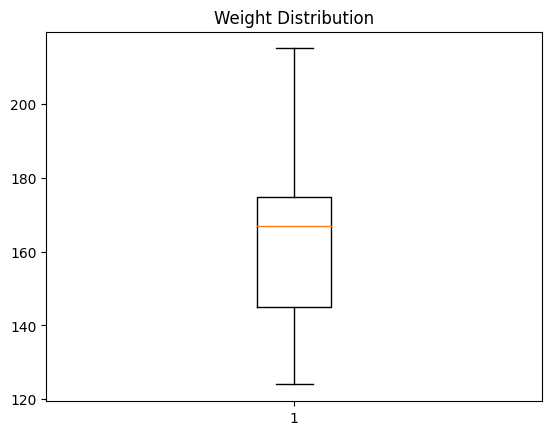

In [747]:
# Outliers for Player's Weight + Height

# Convert Height and Weight Columns into numeric values
pl_aw['height'] = pd.to_numeric(pl_aw['height'], errors='coerce')
pl_aw['weight'] = pd.to_numeric(pl_aw['weight'], errors='coerce')

pl_tm['height'] = pd.to_numeric(pl_tm['height'], errors='coerce')
pl_tm['weight'] = pd.to_numeric(pl_tm['weight'], errors='coerce')

pl_aw = pl_aw.dropna(subset=['height', 'weight'])
pl_tm = pl_tm.dropna(subset=['height', 'weight'])

height_zscores = stats.zscore(pl_aw['height'])
weight_zscores = stats.zscore(pl_aw['weight'])

# Plot boxplot
print("Height Z-Score\n", height_zscores)
print("\nWeight Z-Score\n", weight_zscores)

plt.title('Height Distribution')
plt.boxplot(pl_aw['height'])
plt.show()

plt.title('Weight Distribution')
plt.boxplot(pl_aw['weight'])
plt.show()

Team Played minutes Z-Score
 0    -1.387722
1    -1.261994
2    -1.261994
3    -1.764905
4    -1.639177
        ...   
75    1.001108
76    0.749653
77    1.378292
78    0.875380
79    0.623925
Name: min, Length: 80, dtype: float64


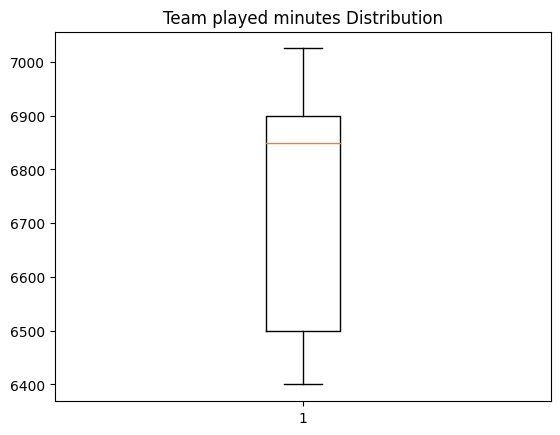

In [748]:
# Outlier for Team's played minutes

tm_psa['min'] = pd.to_numeric(tm_psa['min'], errors='coerce')
cc_tm['min'] = pd.to_numeric(cc_tm['min'], errors='coerce')

tm_psa = tm_psa.dropna(subset=['min'])
cc_tm = cc_tm.dropna(subset=['min'])


print("Team Played minutes Z-Score\n", stats.zscore(tm_psa['min']))
plt.title('Team played minutes Distribution')
plt.boxplot(tm_psa['min'])
plt.show()

Player Played minutes Z-Score
 0       0.958997
1       0.844940
2       0.808776
3      -0.109242
4       0.767048
          ...   
1871   -1.291537
1872   -0.245554
1873    0.836594
1874   -1.311010
1875   -1.311010
Name: minutes, Length: 1876, dtype: float64


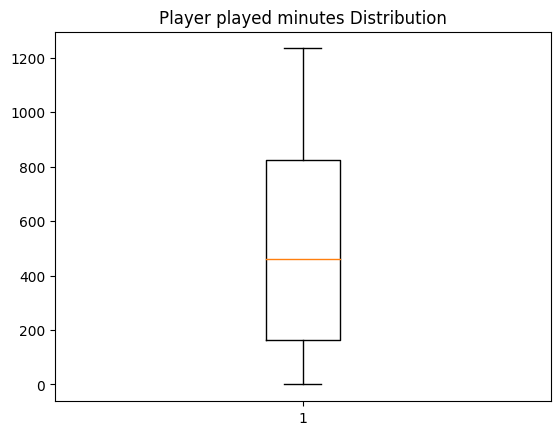

In [749]:
# Outlier for Player's played minutes

pl_tm['minutes'] = pd.to_numeric(pl_tm['minutes'], errors='coerce')

print("Player Played minutes Z-Score\n", stats.zscore(pl_tm['minutes']))
plt.title('Player played minutes Distribution')
plt.boxplot(pl_tm['minutes'])
plt.show()

Team's Offense Score Z-Score
 0     0.273442
1    -0.913695
2    -1.015958
3    -1.055974
4    -1.180468
        ...   
75    0.895910
76    3.301308
77    0.580230
78    0.531322
79    0.762524
Name: o_pts, Length: 80, dtype: float64


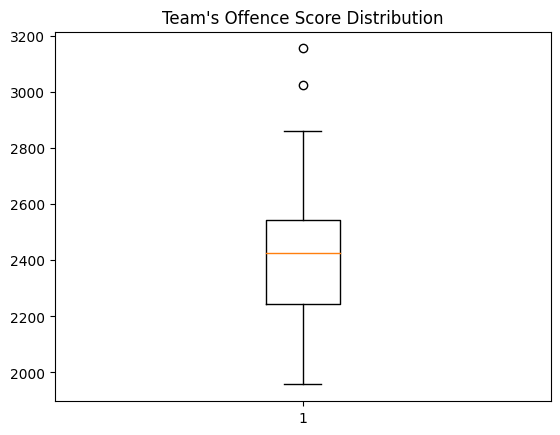

Team's Defense Score Z-Score
 0    -1.182075
1    -0.441685
2    -0.933801
3    -0.494887
4    -1.319513
        ...   
75    1.455843
76    3.096229
77    0.635650
78    0.733186
79    1.282937
Name: d_pts, Length: 80, dtype: float64


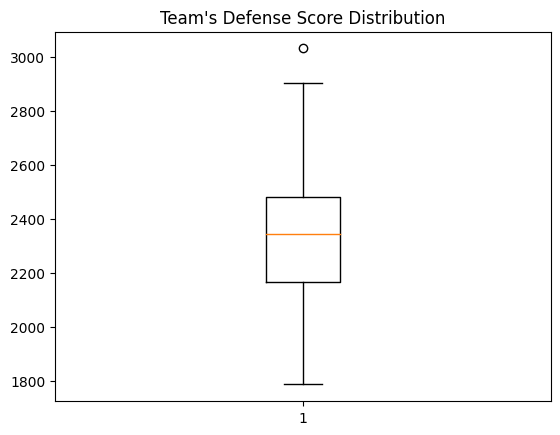

In [750]:
# Outlier Team points

tm_psa['o_pts'] = pd.to_numeric(tm_psa['o_pts'], errors='coerce')

print("Team's Offense Score Z-Score\n", stats.zscore(tm_psa['o_pts']))
plt.title("Team's Offence Score Distribution")
plt.boxplot(tm_psa['o_pts'])
plt.show()

tm_psa['d_pts'] = pd.to_numeric(tm_psa['d_pts'], errors='coerce')

print("Team's Defense Score Z-Score\n", stats.zscore(tm_psa['d_pts']))
plt.title("Team's Defense Score Distribution")
plt.boxplot(tm_psa['d_pts'])
plt.show()

Player's Scores Z-Score
 0       1.029626
1       0.850548
2       0.875248
3      -0.186869
4       0.788797
          ...   
1871   -1.051383
1872   -0.532675
1873    1.418657
1874   -1.020508
1875   -1.026683
Name: points, Length: 1876, dtype: float64


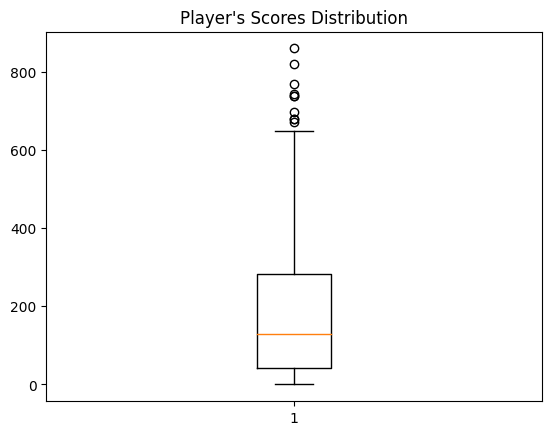

In [751]:
# Outlier Player points

pl_tm['points'] = pd.to_numeric(pl_tm['points'], errors='coerce')

print("Player's Scores Z-Score\n", stats.zscore(pl_tm['points']))
plt.title("Player's Scores Distribution")
plt.boxplot(pl_tm['points'])
plt.show()

In [752]:
# TODO: Feature engineering, number of awards per player/coach, number of awards per team
# TODO: Meter os graficos das college direitos
# TODO: Graficos Z-Score